In [ ]:
!pip install albumentations
!pip install torchmetrics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import cv2
import cv2 as cv
import os
import pathlib
import sys
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torchmetrics
from Dataloaders import supervised_loader, test_loader, supervised_train_transform, test_transform

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

model = model.to(DEVICE)


In [4]:
LEARNING_RATE = 3e-5
BATCH_SIZE = 8
NUM_EPOCHS = 50
NUM_WORKERS = 2
IMAGE_HEIGHT = 736 
IMAGE_WIDTH = 1280 
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "segmentation_data/train_imgs"
TRAIN_MASK_DIR = "segmentation_data/train_masks"
VAL_IMG_DIR = "segmentation_data/val_imgs"
VAL_MASK_DIR = "segmentation_data/val_masks"

In [5]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [13]:
# val_data_size = 250
# ranset = set()
# while (len(ranset) <= val_data_size):
#     ranset.add(np.random.randint(0, 2001))

In [14]:
# import shutil
# import os

# imlis = os.listdir("images")
# lablis = os.listdir("thims")

In [15]:
# for i in ranset:
#     shutil.move(f"images/{imlis[i]}", "val_im")
#     shutil.move(f"thims/{lablis[i]}", "val_lab")

In [6]:
## loading dataloaders

train_data_loader = supervised_loader(image_dir = TRAIN_IMG_DIR, mask_dir= TRAIN_MASK_DIR,
                                      transform=supervised_train_transform, batch_size=BATCH_SIZE, shuffle=True, num_workers=4,
                                      shape = (IMAGE_WIDTH, IMAGE_HEIGHT))

val_data_loader = supervised_loader(image_dir = VAL_IMG_DIR, mask_dir= VAL_MASK_DIR,
                                      transform=test_transform, batch_size=BATCH_SIZE, shuffle=False, num_workers = 4,
                                      shape = (IMAGE_WIDTH, IMAGE_HEIGHT))

In [7]:
iou_fn = torchmetrics.classification.JaccardIndex(task = 'binary', threshold = 0., num_classes = 2)

epochs = (range(NUM_EPOCHS))

val_loss = []
train_loss = []

train_iou = []
val_iou = []

max_val_iou = 0
for epoch in epochs:
    
    total_val_loss = 0
    total_train_loss = 0
    total_train_iou = 0
    total_val_iou = 0
    
    ## training part

    for batch_idx, (data, targets) in enumerate(train_data_loader):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        iou_train = iou_fn(predictions.to("cpu"), ((targets > 0)*1).to("cpu"))
        total_train_iou += iou_train.item()
        # loop.set_postfix(loss=loss.item(), iou_loss = iou_train_loss)
        total_train_loss += loss.item()
        print(f" Epoch - {epoch+1}, Step - {batch_idx+1}/{len(train_data_loader)}, Training_Loss - {round(total_train_loss/(batch_idx+1), 4)}, Train_mIOU - {round(total_train_iou/(batch_idx+1), 4)}", end="\r")
    total_train_loss = total_train_loss/(batch_idx+1)
    total_train_iou = total_train_iou/(batch_idx+1)
    train_loss.append(total_train_loss)
    train_iou.append(total_train_iou)

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(val_data_loader):
            data = data.to(device=DEVICE)
            targets = targets.float().unsqueeze(1).to(device=DEVICE)

            predictions = model(data)
            loss = loss_fn(predictions, targets)
            total_val_loss += loss.item()
            iou_val = iou_fn(predictions.to("cpu"), ((targets > 0)*1).to("cpu"))
            total_val_iou += iou_val.item()
            # val_loop.set_postfix(val_loss=loss.item(), iou_loss = iou_val_loss)
    total_val_loss = total_val_loss/(batch_idx+1)
    total_val_iou = total_val_iou/(batch_idx+1)
    val_loss.append(total_val_loss)
    val_iou.append(total_val_iou)
    print(f" Epoch - {epoch+1}, Training_Loss - {round(total_train_loss, 4)}, Train_mIOU - {round(total_train_iou, 4)}, Training_Loss - {round(total_val_loss, 4)}, val_mIOU - {round(total_val_iou, 4)}")

    if total_val_iou>max_val_iou:
        print(f"Validation mIOU increased from {max_val_iou} to {total_val_iou}, Saving Model....")
        torch.save(model.state_dict(), "best_model.ckpt")
        max_val_iou = total_val_iou

 Epoch - 1, Training_Loss - 0.2482, Train_mIOU - 0.8993, Training_Loss - 0.1344, val_mIOU - 0.9778
Validation mIOU increased from 0 to 0.9778438591957093, Saving Model....
 Epoch - 2, Training_Loss - 0.1132, Train_mIOU - 0.9798, Training_Loss - 0.0939, val_mIOU - 0.9822
Validation mIOU increased from 0.9778438591957093 to 0.9822370767593384, Saving Model....
 Epoch - 3, Training_Loss - 0.0843, Train_mIOU - 0.9831, Training_Loss - 0.0727, val_mIOU - 0.9848
Validation mIOU increased from 0.9822370767593384 to 0.9848112177848816, Saving Model....
 Epoch - 4, Training_Loss - 0.0667, Train_mIOU - 0.9843, Training_Loss - 0.0582, val_mIOU - 0.9854
Validation mIOU increased from 0.9848112177848816 to 0.9853756952285767, Saving Model....
 Epoch - 5, Training_Loss - 0.0539, Train_mIOU - 0.9852, Training_Loss - 0.0476, val_mIOU - 0.9864
Validation mIOU increased from 0.9853756952285767 to 0.9864123439788819, Saving Model....
 Epoch - 6, Training_Loss - 0.045, Train_mIOU - 0.9857, Training_Loss - 

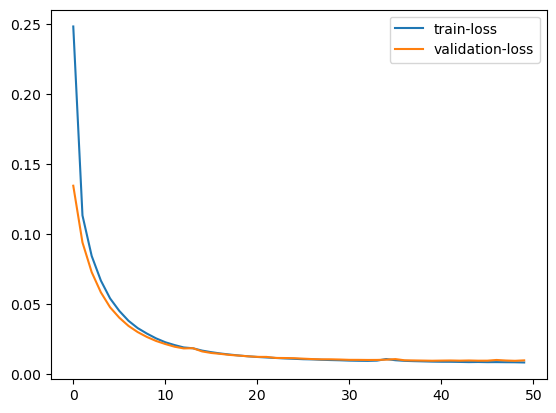

In [8]:
plt.plot(train_loss, label="train-loss")
plt.plot(val_loss, label="validation-loss")
plt.legend()
plt.savefig("results/supervised_unet_loss.png")

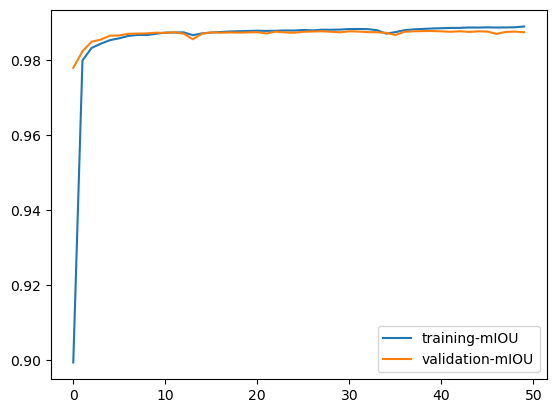

In [9]:
plt.plot(train_iou, label = "training-mIOU")
plt.plot(val_iou, label = "validation-mIOU")
plt.legend()
plt.savefig("results/supervised_unet_miou.png")